Capstone III: Unsupervised Learning

A credit card company wants to segment its customers.

Data set from Kaggle:
https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions/data

Data covers 2000 synthetic consumers resident in the United States who travel the world.

Data definitions:

* User: Numerical digits representaing a user.
* Card: Numerical digits representing a card. One user can have multiple cards.
* MCC (Merchant Category Code): 4 digit numbers that credit card companies use to classify purchases.



In [1]:
import pandas as pd
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import classification_report, confusion_matrix

# from google.colab import drive
# drive.mount('/content/drive')

# One user
#df = pd.read_csv("/content/drive/MyDrive/python_for_data_scientists/example_data/user0_cc_transactions.csv", encoding='unicode_escape')

# 2000 users with 2 million data points. Sample 100k. Runtime: 2m.
#df = pd.read_csv("/content/drive/MyDrive/python_for_data_scientists/example_data/cc_transactions_ibm_v2.csv").sample(100000, random_state=12)

# 2000 users with 2 million data points. Runtime: 80s.
# df = pd.read_csv("/content/drive/MyDrive/python_for_data_scientists/example_data/cc_transactions_ibm_v2.csv")

# Local drive, 42s.
df = pd.read_csv("C:\misc\CS\python_for_data_scientists\example_data\cc_transactions_ibm_v2.csv")
print(df.head(5))


   User  Card  Year  Month  Day   Time   Amount           Use Chip  \
0     0     0  2002      9    1  06:21  $134.09  Swipe Transaction   
1     0     0  2002      9    1  06:42   $38.48  Swipe Transaction   
2     0     0  2002      9    2  06:22  $120.34  Swipe Transaction   
3     0     0  2002      9    2  17:45  $128.95  Swipe Transaction   
4     0     0  2002      9    3  06:23  $104.71  Swipe Transaction   

         Merchant Name  Merchant City Merchant State      Zip   MCC Errors?  \
0  3527213246127876953       La Verne             CA  91750.0  5300     NaN   
1  -727612092139916043  Monterey Park             CA  91754.0  5411     NaN   
2  -727612092139916043  Monterey Park             CA  91754.0  5411     NaN   
3  3414527459579106770  Monterey Park             CA  91754.0  5651     NaN   
4  5817218446178736267       La Verne             CA  91750.0  5912     NaN   

  Is Fraud?  
0        No  
1        No  
2        No  
3        No  
4        No  


In [2]:
print("Data types :\n", df.dtypes, "\n")

Data types :
 User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time               object
Amount             object
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
Is Fraud?          object
dtype: object 



# Explore the data

In [3]:
print("Shape :", df.shape, "\n")
print("Columns :\n", df.columns, "\n")
print("Data types :\n", df.dtypes, "\n")
print("Missing values :\n", df.isna().sum(), "\n")
print("Duplicate rows :\n", df.duplicated().sum())

Shape : (24386900, 15) 

Columns :
 Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?'],
      dtype='object') 

Data types :
 User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time               object
Amount             object
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
Is Fraud?          object
dtype: object 

Missing values :
 User                     0
Card                     0
Year                     0
Month                    0
Day                      0
Time                     0
Amount                   0
Use Chip                 0
Merchant Name            0
Merchant City            0
Merchant State     2720821
Zip                2878

In [4]:
# Remove duplicate values.
df = df.drop_duplicates()

In [5]:
# Change time from object to time
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]
df = df.drop(['Time'], axis=1)

# Remove '$' from Amount column and change to float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

# One hot encode 'Is Fraud?' column
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [6]:
df.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Amount            float64
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
Is Fraud?           int64
Hour               object
Minute             object
dtype: object

Merchant State and Zip have missing values. Merchant State and ZIP are a function of Merchant City

In [7]:
# Convert Strings, Ints, and Floats to Objects
df['Merchant Name'] = df['Merchant Name'].astype("object")
df['Card'] = df['Card'].astype("object")

In [8]:
df.shape

(24386834, 16)

# Exploratory Data Analysis: Data Visualization

Review characteristics of transactions

In [9]:
df.nunique()

User                2000
Card                   9
Year                  30
Month                 12
Day                   31
Amount             98952
Use Chip               3
Merchant Name     100343
Merchant City      13429
Merchant State       223
Zip                27321
MCC                  109
Errors?               23
Is Fraud?              2
Hour                  24
Minute                60
dtype: int64

Convert year, month, and day to Day of the Week.

In [10]:
# Convert year, month, and day to datetime.
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Map datetime to day and create new column 'Day of Week'.
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['Day of Week'] = df['Date'].dt.dayofweek.map(days)

Fraud vs. dollar amount:

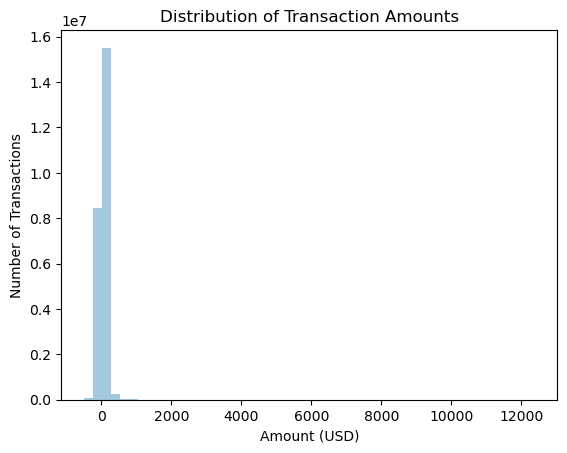

In [11]:
sns.distplot(df['Amount'].astype(float), kde=False)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount (USD)')
plt.ylabel('Number of Transactions')
plt.show()

Transactions vs. State or Country:

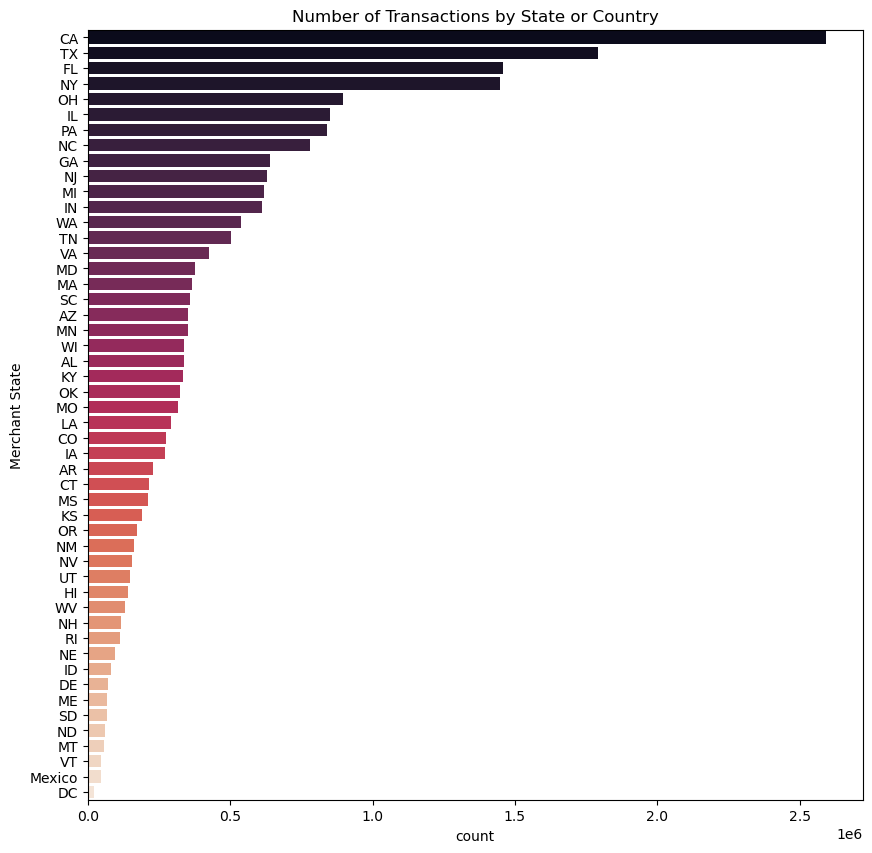

In [12]:
plt.figure(figsize=(10, 10))
sns.countplot(data=df, y='Merchant State', order=df['Merchant State'].value_counts().head(50).index, palette='rocket')
plt.title('Number of Transactions by State or Country')
plt.show()

Transactions vs. City:
Since there are many cities, I picked the top 30.

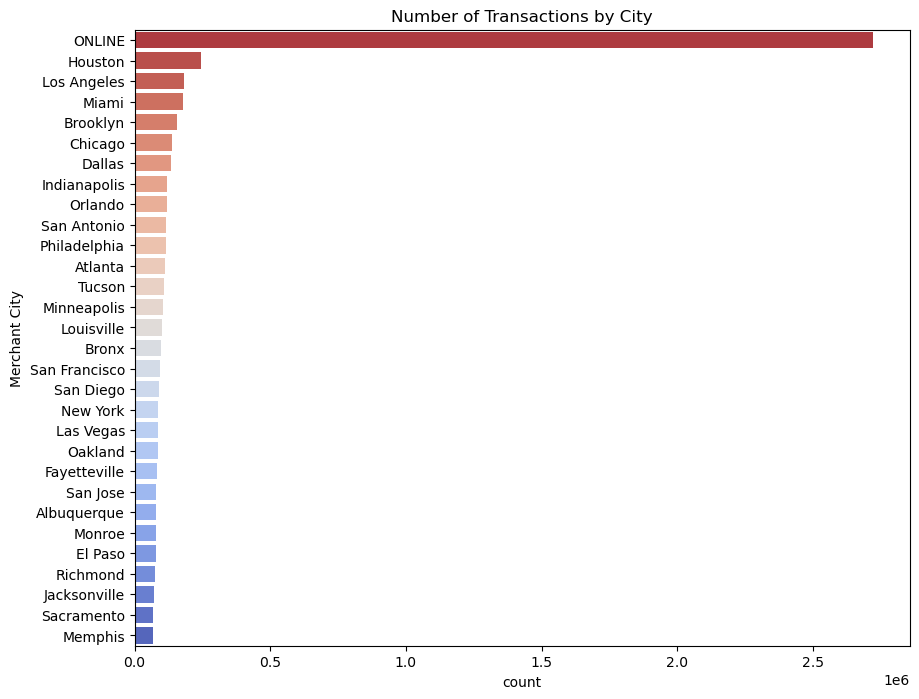

In [13]:
plt.figure(figsize=(10, 8))
top_30_cities = df['Merchant City'].value_counts().head(30).index
sns.countplot(data=df, y='Merchant City', order = top_30_cities , palette='coolwarm_r')
plt.title('Number of Transactions by City')
plt.show()

Transactions vs. Year:

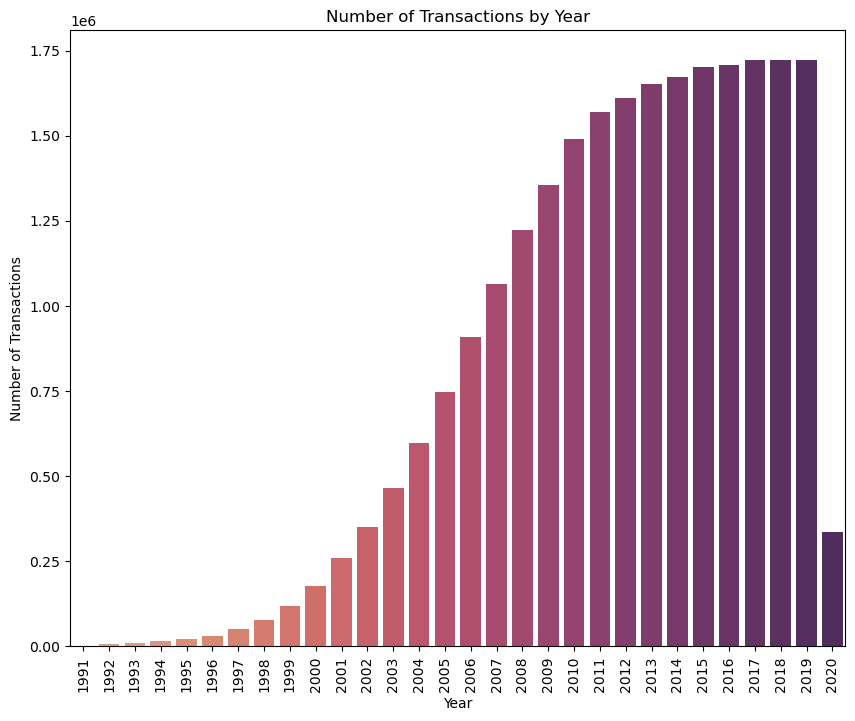

In [29]:
plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='Year', palette='flare')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Year')
plt.show()

Transactions vs. Month:

In [15]:
# Map month int to categorical labels.
month = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df['Month'] = df['Month'].map(month)

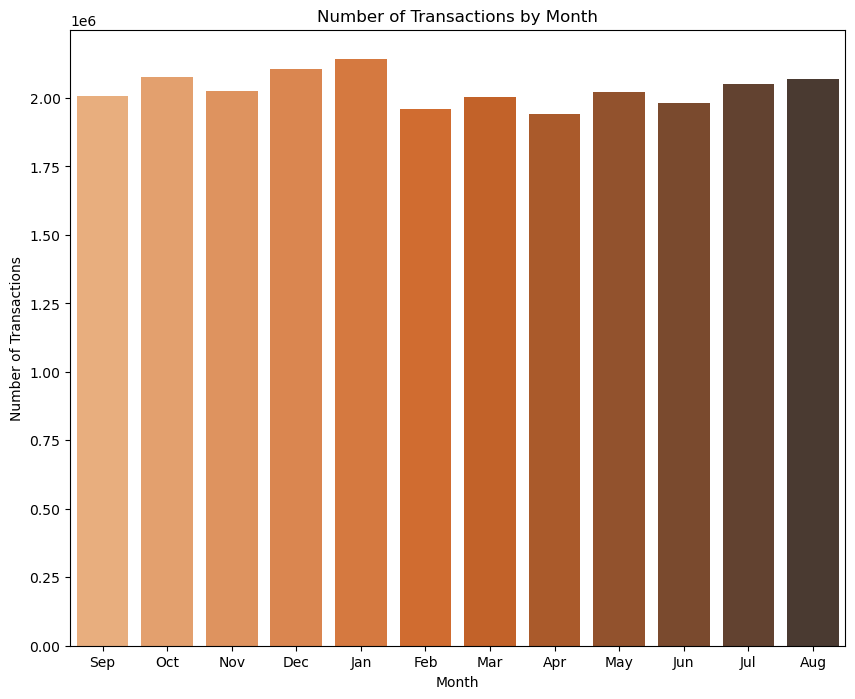

In [16]:
# Plot Fraud vs month:
plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='Month', palette='Oranges_d')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Month')
plt.show()

Transactions vs. Day of the week:

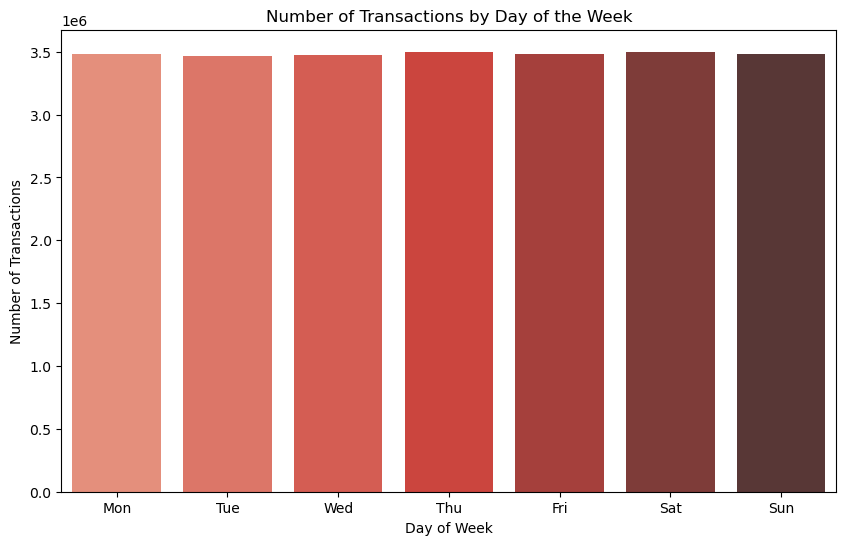

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Day of Week', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], palette="Reds_d")
plt.xlabel('Day of Week')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Day of the Week')
plt.show()

Transactions vs. Hour of the day:

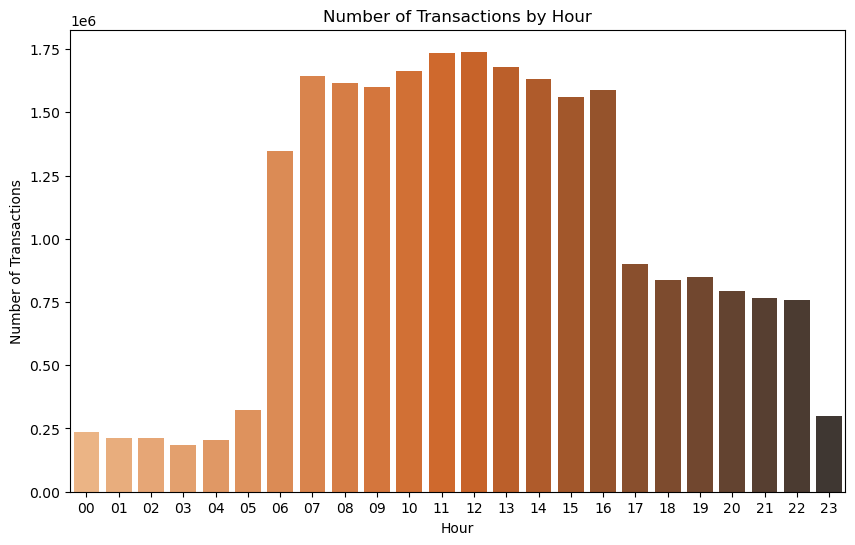

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Hour', order=sorted(df['Hour'].unique()), palette = 'Oranges_d')
plt.title('Number of Transactions by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.show()

Transactions vs. method:

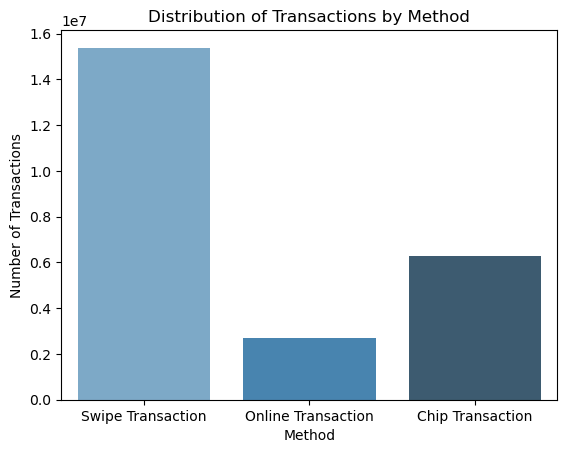

In [19]:
sns.countplot(df, x='Use Chip', palette='Blues_d')
plt.title('Distribution of Transactions by Method')
plt.xlabel('Method')
plt.ylabel('Number of Transactions')
plt.show()

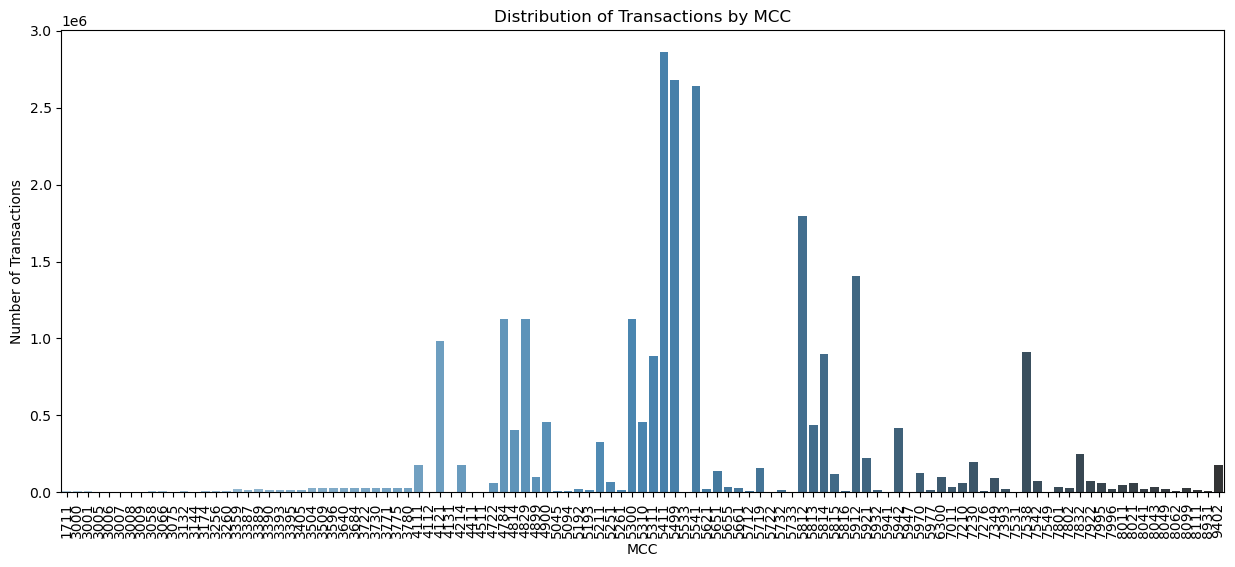

In [20]:
df['MCC'] = df['MCC'].astype("object")
plt.figure(figsize=(15, 6))
sns.countplot(df, x='MCC', palette='Blues_d')
plt.title('Distribution of Transactions by MCC')
plt.xlabel('MCC')
plt.xticks(rotation=90)
plt.ylabel('Number of Transactions')
plt.show()

# Feature Engineering

From EDA, I will select features that are important for segmenting customers.
* Total amount spent per user
* Total transactions by user

In [37]:
user_total_amount = df.groupby('User')['Amount'].sum().reset_index()
user_total_amount.columns = ['UserID', 'TotalAmount']
user_total_transactions = df.groupby('User')['Card'].count().reset_index()
user_total_transactions.columns = ['UserID', 'Transactions']
cluster_features = user_total_amount.merge(user_total_transactions, on='UserID')

In [38]:
print(cluster_features.shape)
print(cluster_features.head())

(2000, 3)
   UserID  TotalAmount  Transactions
0       0   1622991.69         19963
1       1    723491.89          8919
2       2   1475933.36         41978
3       3   1186497.51         10117
4       4   1798790.91         18542


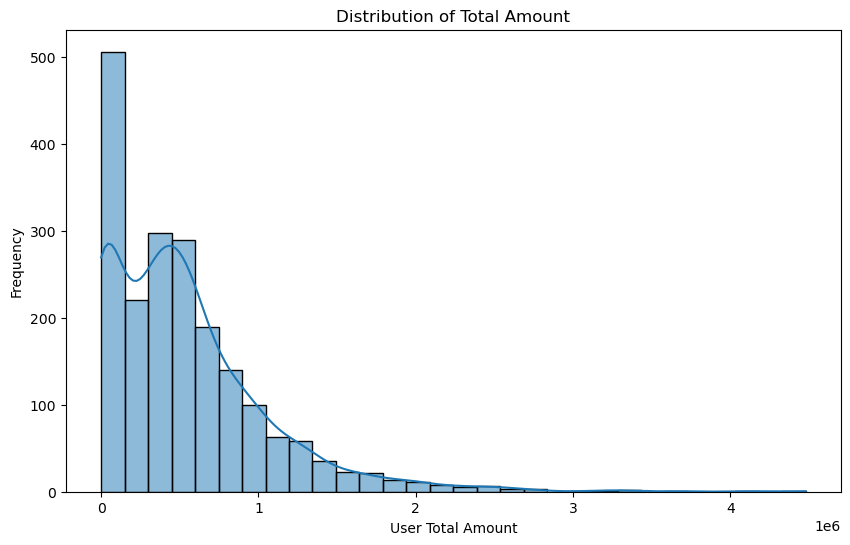

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(cluster_features['TotalAmount'], bins=30, kde=True)
plt.title('Distribution of Total Amount')
plt.xlabel('User Total Amount')
plt.ylabel('Frequency')
plt.show()

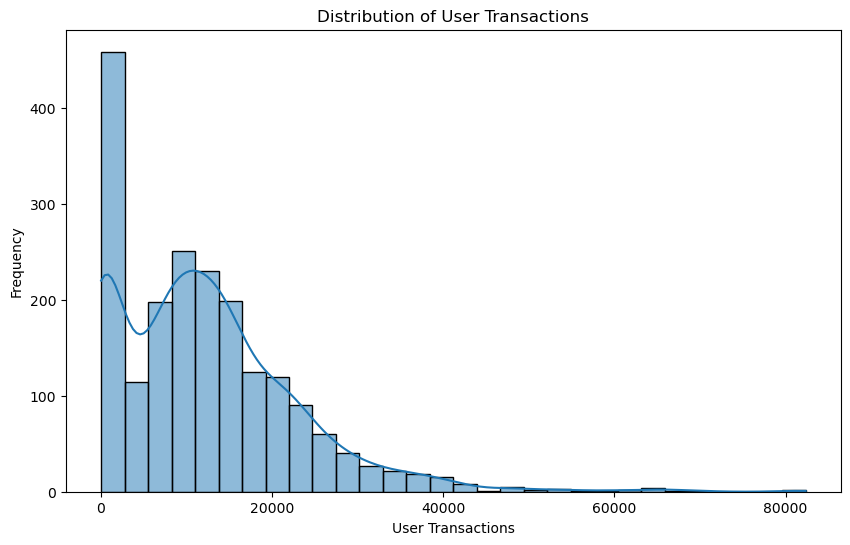

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(cluster_features['Transactions'], bins=30, kde=True)
plt.title('Distribution of User Transactions')
plt.xlabel('User Transactions')
plt.ylabel('Frequency')
plt.show()

Model with K Means

In [41]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(cluster_features[['TotalAmount', 'Transactions']])

# Defining the k-means
kmeans_cluster = KMeans(n_clusters=5, random_state=5)

# Fit model
cluster_features['Cluster'] = kmeans_cluster.fit_predict(features_scaled)

Cluster 1:
            UserID   TotalAmount  Transactions  Cluster  Cluster_new
count   379.000000  3.790000e+02    379.000000    379.0   379.000000
mean    949.052770  1.094729e+06  24377.324538      1.0     2.282322
std     561.671313  3.111948e+05   5991.533381      0.0     0.960588
min       0.000000  4.552293e+05  11856.000000      1.0     1.000000
25%     488.500000  8.654807e+05  20131.500000      1.0     1.000000
50%     932.000000  1.053320e+06  23370.000000      1.0     3.000000
75%    1407.000000  1.274297e+06  27468.500000      1.0     3.000000
max    1997.000000  2.009205e+06  47282.000000      1.0     3.000000
Cluster 2:
            UserID   TotalAmount  Transactions  Cluster  Cluster_new
count   868.000000  8.680000e+02    868.000000    868.0   868.000000
mean   1031.047235  5.207318e+05  12617.142857      2.0     2.876728
std     566.495912  1.750841e+05   3683.311049      0.0     1.452759
min       1.000000  1.301372e+05   3792.000000      2.0     1.000000
25%     542.

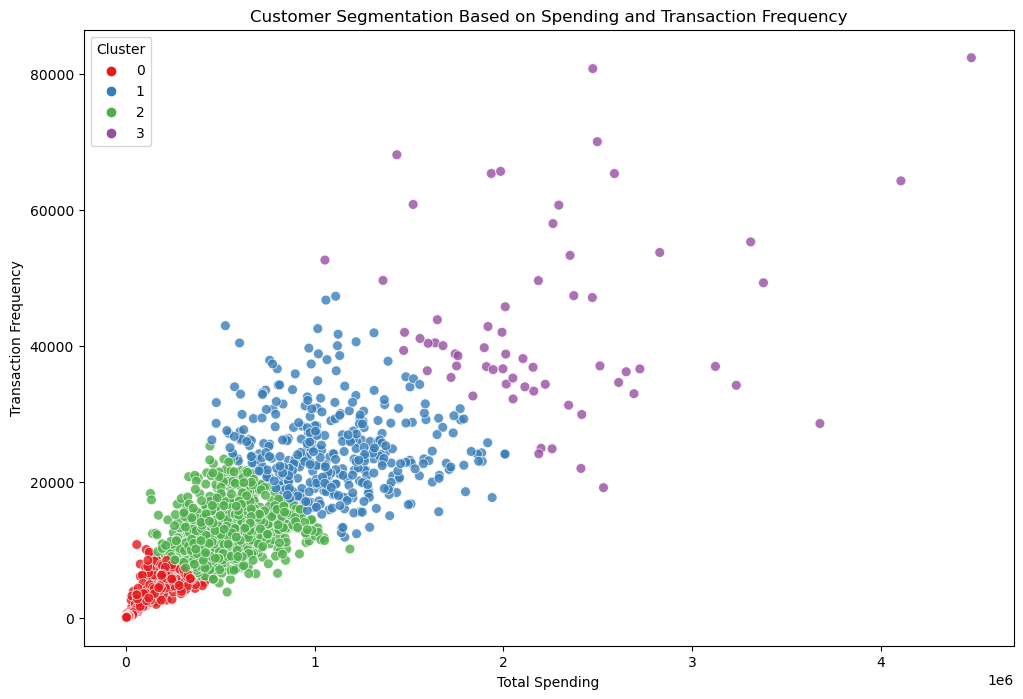

In [47]:
# Analyze clusters
for cluster in cluster_features['Cluster'].unique():
    print(f'Cluster {cluster}:')
    print(cluster_features[cluster_features['Cluster'] == cluster].describe())
    
# Plot the clusters based on user total amount and transactions
plt.figure(figsize=(12, 8))
sns.scatterplot(data=cluster_features, x='TotalAmount', y='Transactions', hue='Cluster', palette='Set1', s=50, alpha=0.8)
plt.title('Customer Segmentation Based on Spending and Transaction Frequency')
plt.xlabel('Total Spending')
plt.ylabel('Transaction Frequency')
plt.legend(title='Cluster')
plt.show()

In [48]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.model_selection import train_test_split

# Silhouette Score
silhouette_avg = silhouette_score(features_scaled, cluster_features['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.5156731837830976


In [49]:
# Re-run KMeans with a different random state and compare the clusters
kmeans_new = KMeans(n_clusters=5, random_state=12)
cluster_features['Cluster_new'] = kmeans_new.fit_predict(features_scaled)
ari_score = adjusted_rand_score(cluster_features['Cluster'], cluster_features['Cluster_new'])
print(f'Adjusted Rand Index: {ari_score}')

# Split the data into train and test sets
X_train, X_test = train_test_split(features_scaled, test_size=0.2, random_state=10)

# Fit KMeans on the train set and predict the test set
kmeans_train = KMeans(n_clusters=5, random_state=10)
train_clusters = kmeans_train.fit_predict(X_train)
test_clusters = kmeans_train.predict(X_test)

# Calculate silhouette score for the test set
test_silhouette_score = silhouette_score(X_test, test_clusters)
print(f'Silhouette Score on Test Set: {test_silhouette_score}')

Adjusted Rand Index: 0.5363572694000199
Silhouette Score on Test Set: 0.4880364620584703


In [ ]:
from sklearn.cluster import DBSCAN
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=2, metric="euclidean")

# Fit model
dbscan_ = dbscan_cluster.fit_predict(X_std)